## Notes and ideas :
- look for the frequency of publication of articles.
#### Features to be included in the template:
- Images with more weighting than the body of the article ( they may contain more information and impact on the reader).
- Measure the degree of objectivity or subjectivity (using the Vader metric) of bbc news writers by calculating the average distance of a bbc article from neutralitypoint (this could be done by applying the prediction model on more various categories -hence more data injected) , input this into your main model.
- Count the number of authors and see if studying each author separately is efficient, knowing that no much writters write in the climate rubrique.
- A picture (if subjective) is worth a thousand words", but if it is not significant, i.e. objective, it has no impact, no matter how much we consider it, the final result will not be affected. so we multiply the picture text (not a thousand times ofc hhh) to ponder with the rest of the article content.
- study the sentiment of news about some emerging notion : metaverse (in cathefories and NER) maybe something else.
## Insight :
- Transfer learning is already applied, make sure in the insight that you offer a path to relearn the Vader program to articles similar to bbc news.  

In [1]:
import os
import csv
import json
import nltk
import spacy 
import shutil
import gcloud
import logging
import requests
import matplotlib
import numpy as np
import pandas as pd
import urllib.request
import networkx as nx
import src.help_NER_UB
from PIL import Image
from spacy import displacy
from tqdm.notebook import *
from bs4 import BeautifulSoup
from itertools import groupby
from spacy.tokens import Span 
import matplotlib.pyplot as plt
from newsapi import NewsApiClient
from spacy.matcher import Matcher 
from matplotlib.pyplot import figure
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from stanfordcorenlp import StanfordCoreNLP
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from src.subject_verb_object_extraction import printDeps, extract_link
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oussama\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


!pip install spacy
!python -m spacy download en_core_web_sm
nltk.download('punkt')
!python -m spacy download en_core_sci_lg

# I- Fetching data :

Used to fetch news data using an original scrapper, including published images, so they be injected into the model as additional features  

In [2]:
def scrap_one_article(url, _, nbr_articles):
    try:
        dirName = 'images'
        os.mkdir(dirName)
    except:
        pass
    url_clean = url
    if url[6:19] == url[26:39]:
        url_clean = url[19:]
        print(url_clean)
    response = requests.get(url_clean)
    soup = BeautifulSoup(response.text, 'lxml')
    csv_file = open('bbc_news.csv', 'a')
    csv_writer = csv.writer(csv_file)
    author = 'BBC News'
    title = None
    csv_writer.writerow(['id', 'url', 'author', 'article_content','images descriptions'])
    try:
        author = soup.find_all(class_ = 'ssrcss-1rv0moy-Contributor')[0].find('strong').text[3:]
    except: #certain articles doesn't contain an element for the author
        pass
    try:
        title = soup.find_all(class_ = 'ssrcss-gcq6xq-StyledHeading')[0].text
    except: 
        pass
    try:
        date = soup.find_all(class_ = 'ecn1o5v2')[0].find('time')['datetime'][:10]
    except: 
        date = None
    try:
        cathegory = soup.find_all(class_ = 'ed0g1kj0')[0].text
    except: 
        cathegory = 'General'
    Content_list = soup.find_all(class_ = 'eq5iqo00')
    article_content = build_text(Content_list)
    if article_content[:28] == 'This video can not be played':
        article_content = article_content[29:]
    Images_descriptions = download_images_description(soup)    
    print('Article ', _ ,'/',nbr_articles,' - ',f'[{date}] [{cathegory}][{author}].')
    article_dic= {'id': _ ,'url': url_clean,'author':author,'date': date,'cathegory':cathegory,'title':title,'article_content':article_content, 'Image count': len(Images_descriptions), 'images descriptions':Images_descriptions}
    return article_dic

In [3]:
def build_text(list_):
    list_.pop()
    return '\n'.join([x.text for x in list_])
def dl_img(url, file_path, file_name):
    full_path = file_path + file_name + '.jpg'
    urllib.request.urlretrieve(url, full_path)
    return full_path
def download_images(soup_result,article_index,nbr_articles):
    nbr_img = 0
    try:
        os.mkdir(f'images/Article{article_index}')
    except:
        pass
    img_results = [res['src'] for res in soup_result.find_all('img')][-12:]
    print(len(img_results))
    for _ in tqdm (range(1,len(img_results))):
        image_link = img_results[_]
        image_link_loc = f'images/Article{article_index}/'
        file_name = f'img{_}'
        try:
            image_link_local = dl_img(image_link,image_link_loc, file_name)
            i += 1
            nbr_img+=1
        except:
            pass
        return nbr_img
def download_images_description(soup_result):
    nbr_img = 0
    try:
        os.mkdir(f'images/Article{article_index}')
    except:
        pass
    img_results = [res['alt'] for res in soup_result.find_all('img')][-12:]
    img_results
    return img_results
def get_links_list(soup):
        results = soup.find_all('a',class_ = 'qa-heading-link')
        links_list = ['http://www.bbc.com/'+res['href'] if (res['href'][6:19] != res['href'][26:39]) else res['href'] for res in results]
        return links_list


In [4]:
def scrap_bbc_articles(category_url):
    try:    
        shutil.rmtree('images') 
    except:
        pass
    url = category_url
    response = requests.get(url)
    print('Request status (200 means a succesful request): ',response.status_code)
    soup = BeautifulSoup(response.text, 'lxml')
    links = get_links_list(soup)
    print('fetching begun ...')
    print('Fetching data from ',len(links) - 5 ,' bbc news articles')
    results = []
    print('------------------------------------')
    for _ in tqdm(range(1,len(links)-5), desc = 'Fetching articles'):  # Covers all the articles len(links)+1
        try: 
            A = scrap_one_article(links[_], _, len(links))
            results.append(A)
        except:
            pass
    return results


In [5]:
climate_url = 'https://www.bbc.com/news/science-environment-56837908'
data = scrap_bbc_articles(climate_url)
def fetch_clean_data(data_list): 
    article_results = [] 
    for i in range(len(data_list)):
        try:
            article_dict = {}
            article_dict['id'] = data_list[i]['id']
            article_dict['cathegory'] = data_list[i]['cathegory']
            article_dict['author'] = data_list[i]['author']
            article_dict['title'] = data_list[i]['title']
            article_dict['Publish date'] = data_list[i]['date']
            article_dict['url'] = data_list[i]['url']
            article_dict['article_content'] = data_list[i]['article_content'].strip("\n").strip("\t")
            article_dict['images descriptions'] = data_list[i]['images descriptions']
            article_results.append(article_dict)
        except IndexError:
            pass
    return article_results

Request status (200 means a succesful request):  200
fetching begun ...
Fetching data from  15  bbc news articles
------------------------------------


Article  1 / 20  -  [2021-12-27] [General][BBC News].
Article  2 / 20  -  [2021-12-27] [COP26][Matt McGrath].
Article  3 / 20  -  [2021-12-27] [Climate change][Justin Rowlatt].
Article  4 / 20  -  [2021-12-26] [Climate change][BBC News].
Article  5 / 20  -  [2021-12-26] [General][BBC News].
Article  6 / 20  -  [2021-12-24] [Climate change][BBC News].
Article  7 / 20  -  [2021-12-24] [General][BBC News].
Article  8 / 20  -  [2021-12-24] [COP26][Martin Webber].
Article  9 / 20  -  [2021-12-24] [Climate change][Marco Silva].
Article  10 / 20  -  [2021-12-21] [Climate change][Louise Cullen].
Article  11 / 20  -  [2021-12-21] [General][BBC News].
Article  12 / 20  -  [2021-12-21] [Climate change][Jesse Preyser].
Article  13 / 20  -  [2021-12-20] [Budget 2021][BBC News].
Article  14 / 20  -  [2021-12-19] [Climate change][BBC News].



In [6]:
Data = pd.DataFrame.from_dict(fetch_clean_data(data))
pd.set_option('max_colwidth', 500)
pd.set_option('max_colwidth', 100)
data_unclean = Data.copy()
Data.head()

,id,cathegory,author,title,Publish date,url,article_content,images descriptions
0,1,General,BBC News,None,2021-12-27,http://www.bbc.com//news/world-latin-america-59801025,"After weeks of heavy rain overwhelming already swollen rivers, two dams in Brazil's Bahia state ...","[Sandstorm, A severe drought in South America is due in part to deforestation in the Amazon jung..."
1,2,COP26,Matt McGrath,Climate change: Huge toll of extreme weather disasters in 2021,2021-12-27,http://www.bbc.com//news/science-environment-59761839,"Weather events, linked to a changing climate, brought misery to millions around the world in 202...","[floods, Desmond Tutu speaking to a conference, A woman walks past a graffiti in Mumbai. Municip..."
2,3,Climate change,Justin Rowlatt,Wildlife's winners and losers of 2021 - and how extreme weather set the tone,2021-12-27,http://www.bbc.com//news/science-environment-59757497,Wildlife across the UK is increasingly suffering the impacts of extreme weather events and natur...,"[Shadowed waxcap, 1px transparent line, Pink waxcap at Jinlye Meadows in Shropshire, 1px transpa..."
3,4,Climate change,BBC News,"Floods getting bigger and more frequent, says river expert",2021-12-26,http://www.bbc.com//news/uk-england-hereford-worcester-59726441,Floods on the River Severn and other waterways in the West Midlands are likely to continue getti...,"[Presentational grey line, Desmond Tutu speaking to a conference, A woman walks past a graffiti ..."
4,5,General,BBC News,None,2021-12-26,http://www.bbc.com//news/world-us-canada-59707864,"Around the US, an estimated three million oil wells have been abandoned. \nMany of the wells are...","[A local woman with a seal carcass in northern Alaska, Stephanie, Archbishop Desmond Tutu, Desmo..."


In [7]:
Data.to_csv('exported_bbc_data.csv')
Data.to_excel('exported_bbc_data.xlsx')


<h1> II- Data preprocessing :</h1>

### 2.1 Introduction
Feature engineering is an important process in the pipeline of any machine learning project.
It involves applying a series of transformations to the data, including
data, including eliminating bad records, encoding variables, scaling variables and finally eliminating
scaling of variables and finally the elimination of variables with a high correlation.
The motivation behind this process is to feed the algorithms with digested data
and to improve their performance by reducing the learning time.
In this project, different data processing techniques were applied to implement the machine learning models.
the machine learning models and improve their performance, which we will discuss below.
we will discuss below.
### 2.2 Missing value rate and zero variance
Here we try to eliminate variables with a very high rate of missing values
or zero variance. The following variables are then removed from our final database

In [8]:
Data.columns

Index(['id', 'cathegory', 'author', 'title', 'Publish date', 'url',
       'article_content', 'images descriptions'],
      dtype='object')

In [9]:
def clean(Data):
    #lower case all content
    #removing punctuation
    Data["Publish date"].fillna( method ='ffill', inplace = True) # Fill NaN values
    return Data
Data = clean(Data)
Data.head()

,id,cathegory,author,title,Publish date,url,article_content,images descriptions
0,1,General,BBC News,None,2021-12-27,http://www.bbc.com//news/world-latin-america-59801025,"After weeks of heavy rain overwhelming already swollen rivers, two dams in Brazil's Bahia state ...","[Sandstorm, A severe drought in South America is due in part to deforestation in the Amazon jung..."
1,2,COP26,Matt McGrath,Climate change: Huge toll of extreme weather disasters in 2021,2021-12-27,http://www.bbc.com//news/science-environment-59761839,"Weather events, linked to a changing climate, brought misery to millions around the world in 202...","[floods, Desmond Tutu speaking to a conference, A woman walks past a graffiti in Mumbai. Municip..."
2,3,Climate change,Justin Rowlatt,Wildlife's winners and losers of 2021 - and how extreme weather set the tone,2021-12-27,http://www.bbc.com//news/science-environment-59757497,Wildlife across the UK is increasingly suffering the impacts of extreme weather events and natur...,"[Shadowed waxcap, 1px transparent line, Pink waxcap at Jinlye Meadows in Shropshire, 1px transpa..."
3,4,Climate change,BBC News,"Floods getting bigger and more frequent, says river expert",2021-12-26,http://www.bbc.com//news/uk-england-hereford-worcester-59726441,Floods on the River Severn and other waterways in the West Midlands are likely to continue getti...,"[Presentational grey line, Desmond Tutu speaking to a conference, A woman walks past a graffiti ..."
4,5,General,BBC News,None,2021-12-26,http://www.bbc.com//news/world-us-canada-59707864,"Around the US, an estimated three million oil wells have been abandoned. \nMany of the wells are...","[A local woman with a seal carcass in northern Alaska, Stephanie, Archbishop Desmond Tutu, Desmo..."


### 2.3 NER : Named entities recognition :
As it is part of the task, we are asked to display sentiment analysis for each NER.
the aim of this sub-section is to try different Nlp models to get thelist of named entities from text.

In [18]:
index = 4
str_ = str(data_unclean.iloc[index]['article_content']) # Article sample
str_

"Around the US, an estimated three million oil wells have been abandoned. \nMany of the wells are emitting harmful methane gases, which are more harmful to the environment than carbon dioxide.\nThat's why Curtis Shuck, a 30-year veteran of the oil industry, has stepped in. \nHe's created Well Done, a not for-profit organisation dedicated to capping the old wells."


#### 2.3.1 Spacy :

SpaCy is a Python software library for automatic language processing developed by Matt Honnibal and Ines Montani. SpaCy is open source software released under the MIT license. The SpaCy library can perform the following analysis operations on texts in over 50 languages : 
- Tokenization 
- NER


In [11]:

nlp = spacy.load("en_core_web_sm")
doc = nlp(str_)
entities = []
labels = []
position_start = []
position_end = []
for ent in doc.ents:
    entities.append(ent)
    labels.append(ent.label_)
    position_start.append(ent.start_char)
    position_end.append(ent.end_char)
data_entities_2 = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})
data_entities_2

,Entities,Labels,Position_Start,Position_End
0,(US),GPE,11,13
1,"(an, estimated, three, million)",CARDINAL,15,41
2,"(Curtis, Shuck)",PERSON,202,214
3,"(30, -, year)",DATE,218,225
4,(Done),ORG,290,294


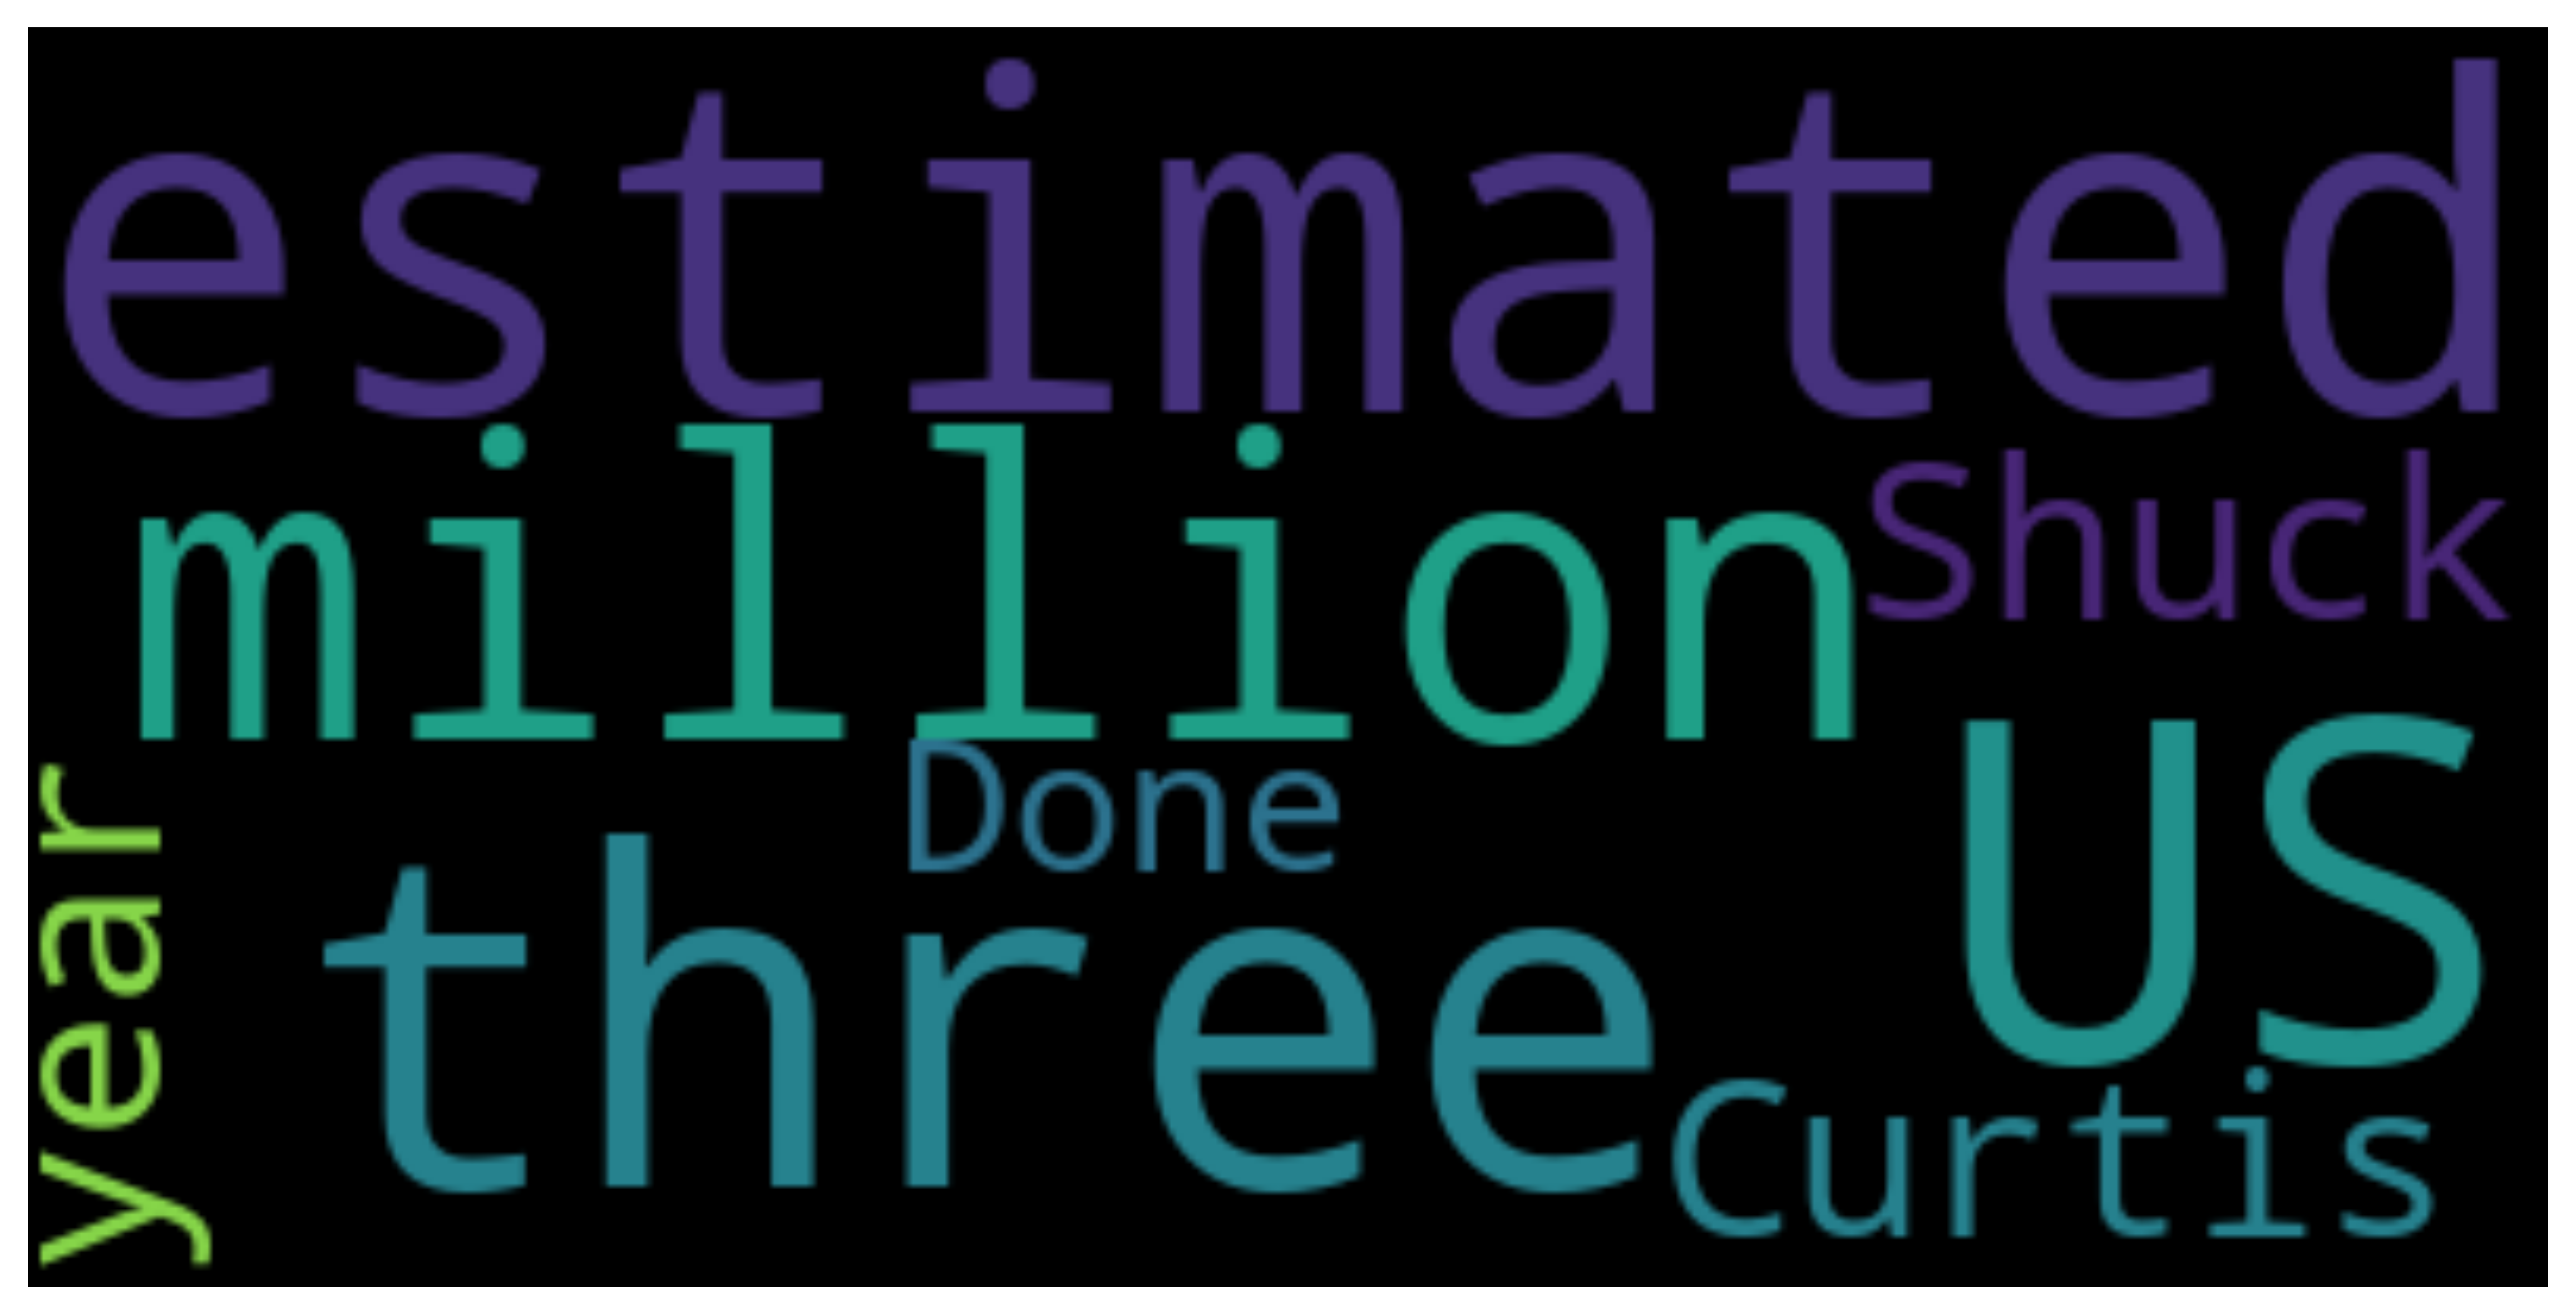

In [12]:
text = ' '.join([str(i) for i in data_entities_2['Entities'].to_list()])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 6)
fig.set_dpi(500)
plt.show()


#### 2.3.2  Standford Ner :

Installation and Configuration: https://medium.com/manash-en-blog/configuring-stanford-parser-and-stanford-ner-tagger-with-nltk-in-python-on-windows-f685483c374a

Stanford link: https://nlp.stanford.edu/software/CRF-NER.html

In [17]:
java = "C:/Program Files/Java/jre1.8.0_311/bin/java.exe"
os.environ["JAVAHOME"] = java
annotators= 'tokenize,ssplit,pos,lemma,ner,parse,depparse,sentiment',
os.environ["CORENLP_HOME"] = "D:/stanford-corenlp-4.3.2/stanford-corenlp-4.3.2.jar/stanford-corenlp-4.3.2/stanford-corenlp-4.3.2.jar"
nlp = StanfordCoreNLP('http://localhost', port=9000,timeout=30000)
text = str_
nlp_results = nlp.annotate(text,properties={
        'annotators':'sentiment, ner, pos',
        'outputFormat': 'json',
        'timeout': 50000,
        })
json_results = json.loads(nlp_results)
sentiment_description = json_results['sentences'][0]['sentiment']
sentiment_value = json_results['sentences'][0]['sentimentValue']
print('sentiment analysis : ',sentiment_description, sentiment_value)

sentiment analysis :  Negative 1


In [32]:
#fetch for results using a google api.
def NE_info_fetch(named_entity):
    url = "https://google-search26.p.rapidapi.com/search"
    Ne = named_entity
    querystring = {"q":Ne,"hl":"en","tbs":"qdr:a",'as_sitesearch':'wikipedia.com'}

    headers = {
        'x-rapidapi-host': "google-search26.p.rapidapi.com",
        'x-rapidapi-key': "ea42e2dcc0msh49ecba51860383ep18d94ejsnbb0488e12e70"
        }

    response = requests.request("GET", url, headers=headers, params=querystring)
    try:
        return (response.json()['results'][0]['snippet'][:200])
    except IndexError :
        return 'Wikipedia'

In [30]:
def get_summary(named_entity,data_unclean,_):
    def sumarize(List):
        result = []
        for _ in List:
            url = "https://api.meaningcloud.com/summarization-1.0"
            querystring = {"txt":_,"of":"json",'key':'1fe6342e2cfafb085d01802a50c98e6d','limit': 10}
            response = requests.request("GET", url, params=querystring)
            result.append(response.json()['summary'])
        return result
    text = str(data_unclean.iloc[index]['article_content'])
    phrases = nltk.tokenize.sent_tokenize(text)
    results = []
    for _ in range(len(phrases)):
        if named_entity in phrases[_]:
            results.append(phrases[_])
            if _ < len(phrases): 
                #return two phrases instead of one, to give more information about thenamed entity
                results.append(phrases[_ + 1]) 
    return sumarize(results)
get_summary('Shuck', data_unclean,index)

["That's why Curtis Shuck, a 30-year veteran of the oil industry, has stepped in.",
 "He's created Well Done, a not for-profit organisation dedicated to capping the old wells."]

In [34]:
#entities_table = pd.concat([data_entities_2[['Entities','Labels']], info], axis=1) 
get_info = lambda x: [get_summary(x,data_unclean,index),NE_info_fetch(x)]
get_info('Shuck')

[["That's why Curtis Shuck, a 30-year veteran of the oil industry, has stepped in.",
  "He's created Well Done, a not for-profit organisation dedicated to capping the old wells."],
 'noun\nan outer covering such as a husk or pod, especially the husk of an ear of maize.,a person or thing regarded as worthless or contemptible.,"he said the idea was a shuck"exclamation\nused to express']

In [42]:
info = data_entities_2[["Entities",'Labels']]
df_result = pd.DataFrame(columns = ['Entities','Labels','Text'])
for _ in tqdm(info.iterrows()):
    #it doesn't append idk whyn
    #don't forget that the output of get info return a list of two list, its not a string , trying using another thing than iloc
    info = get_info(_[1]['Entities'])
    df_result = df_result.append(pd.DataFrame.from_dict({'Entities':_[1]['Entities'], 'Labels': _[1]['Labels'],'summary':info[0],'image description': info[1] }) , ignore_index=True)

TypeError: 'in <string>' requires string as left operand, not spacy.tokens.span.Span